El comparador de fuerza bruta es simple. Toma el descriptor de una característica en el primer conjunto y lo compara con todas las demás características en el segundo conjunto mediante algún cálculo de distancia. Y se devuelve el más cercano.

Para BF Matcher, primero tenemos que crear el objeto BFMatcher usando cv.BFMatcher() . Se necesitan dos parámetros opcionales. El primero es tipo de norma. Especifica la medida de distancia que se utilizará. De forma predeterminada, es cv.NORM_L2 . Es bueno para SIFT, SURF, etc. ( cv.NORM_L1 también está ahí). Para descriptores basados ​​en cadenas binarias como ORB, BRIEF, BRISK, etc., se debe utilizar cv.NORM_HAMMING , que utiliza la distancia de Hamming como medida. Si ORB usa WTA_K == 3 o 4, se debe usar cv.NORM_HAMMING2 .

El segundo parámetro es una variable booleana, crossCheck que es falsa de forma predeterminada. Si es verdadero, Matcher devuelve solo aquellas coincidencias con valor (i,j) tales que el i-ésimo descriptor en el conjunto A tiene el j-ésimo descriptor en el conjunto B como la mejor coincidencia y viceversa. Es decir, las dos características de ambos conjuntos deben coincidir entre sí. Proporciona resultados consistentes y es una buena alternativa a la prueba de proporción propuesta por D. Lowe en el artículo SIFT.

Una vez creado, dos métodos importantes son BFMatcher.match() y BFMatcher.knnMatch() . El primero devuelve la mejor combinación. El segundo método devuelve k mejores coincidencias donde k lo especifica el usuario. Puede resultar útil cuando necesitemos hacer trabajo adicional al respecto.

Al igual que usamos cv.drawKeypoints() para dibujar puntos clave, cv.drawMatches() nos ayuda a dibujar las coincidencias. Apila dos imágenes horizontalmente y dibuja líneas desde la primera imagen a la segunda mostrando las mejores coincidencias. También está cv.drawMatchesKnn que dibuja las k mejores coincidencias. Si k=2, dibujará dos líneas de coincidencia para cada punto clave. Entonces tenemos que pasar una máscara si queremos dibujarla selectivamente.

Estamos utilizando descriptores ORB para hacer coincidir características. Entonces, comencemos cargando imágenes, buscando descriptores, etc.



In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread('resources/box.png',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('resources/box_in_scene.png',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

A continuación, creamos un objeto BFMatcher con medición de distancia cv.NORM_HAMMING (ya que estamos usando ORB) y crossCheck está activado para obtener mejores resultados. Luego usamos el método Matcher.match() para obtener las mejores coincidencias en dos imágenes. Los clasificamos en orden ascendente según sus distancias para que las mejores coincidencias (con distancia baja) aparezcan al frente. Luego sorteamos sólo los primeros 10 partidos (sólo por motivos de visibilidad. Puedes aumentarlo como quieras)

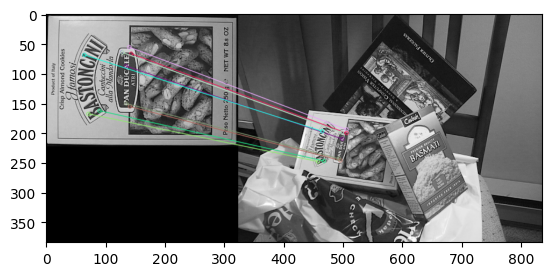

(<matplotlib.image.AxesImage at 0x7fc1d2b163d0>, None)

In [4]:
# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

El resultado de la líneamatches = bf.match(des1,des2) es una lista de objetos DMatch. Este objeto DMatch tiene los siguientes atributos:

DMatch.distance: distancia entre descriptores. Cuanto más bajo, mejor.
DMatch.trainIdx: índice del descriptor en descriptores de trenes
DMatch.queryIdx: índice del descriptor en descriptores de consulta
DMatch.imgIdx: índice de la imagen del tren.


Coincidencia de fuerza bruta con descriptores SIFT y prueba de relación.

Esta vez usaremos BFMatcher.knnMatch() para obtener k mejores coincidencias. En este ejemplo, tomaremos k=2 para poder aplicar la prueba de razón explicada por D. Lowe en su artículo.

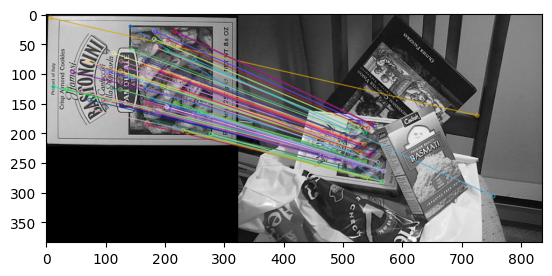

(<matplotlib.image.AxesImage at 0x7fc1d204f430>, None)

In [6]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread('resources/box.png',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('resources/box_in_scene.png',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

Matcher basado en FLANN.

FLANN significa Biblioteca rápida para vecinos más cercanos aproximados. Contiene una colección de algoritmos optimizados para una búsqueda rápida del vecino más cercano en grandes conjuntos de datos y para características de alta dimensión. Funciona más rápido que BFMatcher para grandes conjuntos de datos. Veremos el segundo ejemplo con un comparador basado en FLANN.

Para el comparador basado en FLANN, necesitamos pasar dos diccionarios que especifiquen el algoritmo que se utilizará, sus parámetros relacionados, etc. El primero es IndexParams. Para varios algoritmos, la información que se debe pasar se explica en los documentos de FLANN. Como resumen, para algoritmos como SIFT, SURF, etc. puede pasar lo siguiente:

In [7]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

Mientras usa ORB, puede pasar lo siguiente. Los valores comentados se recomiendan según los documentos, pero en algunos casos no proporcionaron los resultados requeridos. Otros valores funcionaron bien.:

In [8]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2

El segundo diccionario es SearchParams. Especifica el número de veces que se deben recorrer de forma recursiva los árboles del índice. Los valores más altos proporcionan una mayor precisión, pero también requieren más tiempo. Si desea cambiar el valor, pase search_params = dict(checks=100).

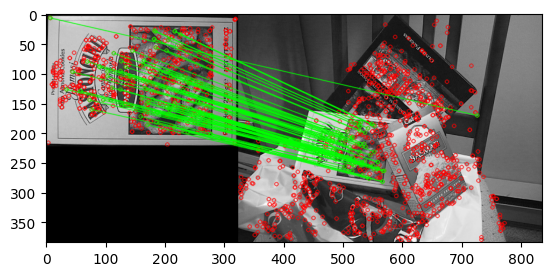

(<matplotlib.image.AxesImage at 0x7fc1d218f7c0>, None)

In [9]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread('resources/box.png',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('resources/box_in_scene.png',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()